In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [2]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *

In [4]:
%matplotlib inline

In [5]:
# Constants
# some useful parameters
startTime =  datetime.strptime('20161201', '%Y%m%d')
endTime = datetime.strptime('20170429', '%Y%m%d')

path = ff.data_path
timeStampNum = 2500
thresholdNum = 0.2
HS300Index ='000300.SH' # HS300 index code
ZZ500Index = '000905.SH' #   ZZ500 index code

In [6]:
# Files to use 
filenamePrice = 'Own_Factor_AdjustedPriceForward-1d.csv'
filenameST = 'LZ_GPA_SLCIND_ST_FLAG.csv'
filenameTradeday = 'LZ_GPA_SLCIND_TRADEDAYCOUNT.csv'
filenameStopFlag = 'LZ_GPA_SLCIND_STOP_FLAG.csv'
filenameIndu = 'LZ_GPA_INDU_ZX.csv'
filenameFCAP = 'LZ_GPA_VAL_A_FCAP.csv'
filenameAdjustFactor = 'LZ_GPA_CMFTR_CUM_FACTOR.csv'
filenameHS300 = 'LZ_GPA_INDXQUOTE_CLOSE.csv'
filenameZXIndustry = 'LZ_GPA_INDU_ZX.csv'
filenameZXExplanation = 'LZ_GPA_TMP_INDU_ZX.csv'

In [7]:
# Own factor
filenameTOV20 = 'Own_Factor_Turnover_Volatility_20D.csv' # group0 最好，有年化 10%的收益率，单调性很好，多空效果也很好，
 #但是市值单调递减，group0市值最大，可能选到了上证50（大市值股票交易比较稳定，因此换手率波动较小）

In [8]:
# Uqer factor
filenameUQAD20 = 'Uqer_factor_AD20.csv'    # group9最好，有2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性（但是单调性反转，长期是group0最小）（证明类动量/价因子还是效果比较好的）
filenameUQATR6 = 'Uqer_factor_ATR6.csv'    # group1最好，有0.2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性

In [9]:
# value
filenamePS = 'LZ_GPA_VAL_PS.csv'  # group0 最好，有年化 5%的收益率，单调性很好，多空效果也很好
filenamePB ='LZ_GPA_VAL_PB.csv'  # group0 最好，有年化 12%的收益率，单调性很好，多空效果也很好 （神级因子）
filenamePE ='LZ_GPA_VAL_PE.csv'  #  group0 最好，有年化 10%的收益率，单调性不是特别完美，但不错，多空效果也很好 

In [10]:
filenameTest = {'PB':filenamePB, 'PS':filenamePS,'TOV20':filenameTOV20,'UQAD20':filenameUQAD20,'UQATR6':filenameUQATR6}
filenameDict = filenameTest

In [11]:
stDF = pd.read_csv(path+filenameST,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
tradeDayDF = pd.read_csv(path+filenameTradeday,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
stopFlagDF = pd.read_csv(path+filenameStopFlag,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

In [12]:
priceData =  pd.read_csv(path+ filenamePrice ,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
benchMarkData = pd.read_csv(path+filenameHS300,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime][ZZ500Index]

In [13]:
LFCAPDF = np.log10(ff.getData(thresholdNum, startTime, endTime,filename = filenameFCAP))

In [14]:
endOfWeekList = sorted(list(set(LFCAPDF.iloc[LFCAPDF.resample('W').size().cumsum().sub(1)].index)))

In [15]:
activeReturnData = ff.calcReturn(priceData, endOfWeekList , benchmark = benchMarkData,activeReturn = True,logReturn = True,shiftVal = -1)

In [16]:
# Generate the useles stock list
filterdict={}
for i in endOfWeekList :
    suspendList = ff.GetSTNewSuspend(i,stDF,tradeDayDF,stopFlagDF)
    filterdict[i] = suspendList
    print i, len(filterdict[i])

2016-12-02 00:00:00 391
2016-12-09 00:00:00 392
2016-12-16 00:00:00 404
2016-12-23 00:00:00 413
2016-12-30 00:00:00 404
2017-01-06 00:00:00 408
2017-01-13 00:00:00 416
2017-01-20 00:00:00 422
2017-01-26 00:00:00 428
2017-02-03 00:00:00 432
2017-02-10 00:00:00 445
2017-02-17 00:00:00 448
2017-02-24 00:00:00 457
2017-03-03 00:00:00 449
2017-03-10 00:00:00 446
2017-03-17 00:00:00 448
2017-03-24 00:00:00 451
2017-03-31 00:00:00 444
2017-04-07 00:00:00 448
2017-04-14 00:00:00 456
2017-04-21 00:00:00 451
2017-04-28 00:00:00 453


In [17]:
IndustryDF = pd.read_csv(path+filenameIndu,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[endOfWeekList]
normalizedLFCAP = ff.winsorAndnorm(LFCAPDF, filterdict, endOfWeekList )

In [18]:
# Creat new dataframe to save the outcome
global returnofFactor
global tValueofFactor
global pValueofFactor
global ICFactor
global ICpValue
returnofFactor = pd.DataFrame(index=endOfWeekList [:-1],columns=[filenameDict.keys()],data=None,dtype = float) 
tValueofFactor = pd.DataFrame(index= endOfWeekList [:-1],columns= [filenameDict.keys()],data=None,dtype = float)
pValueofFactor = pd.DataFrame(index= endOfWeekList [:-1],columns= [filenameDict.keys()],data=None,dtype = float)
ICFactor =  pd.DataFrame(index= endOfWeekList [:-1],columns= [filenameDict.keys()],data=None,dtype = float)
ICpValue = pd.DataFrame(index= endOfWeekList [:-1],columns= [filenameDict.keys()],data=None,dtype = float)

In [19]:
ICpValue

,PB,PS,UQATR6,TOV20,UQAD20
2016-12-02,NaN,NaN,NaN,NaN,NaN
2016-12-09,NaN,NaN,NaN,NaN,NaN
2016-12-16,NaN,NaN,NaN,NaN,NaN
2016-12-23,NaN,NaN,NaN,NaN,NaN
2016-12-30,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN
2017-01-13,NaN,NaN,NaN,NaN,NaN
2017-01-20,NaN,NaN,NaN,NaN,NaN
2017-01-26,NaN,NaN,NaN,NaN,NaN
2017-02-03,NaN,NaN,NaN,NaN,NaN


In [20]:
def modifyUQdata(filename):
    sparedata = pd.read_csv(path+filename,infer_datetime_format=True,parse_dates=[0],index_col=0)
    uqercolumnList = sparedata.columns.tolist()
    uqercolumnName = [x.split('.')[0] for x in uqercolumnList]
    newcolumnList = stDF.columns.tolist()
    newcolumnName = [x.split('.')[0] for x in newcolumnList]
    columndict = dict(zip(newcolumnName,newcolumnList))
    finalcolumns = []
    for stk in uqercolumnName:
        if stk in newcolumnName:
            stk = columndict[stk]
        else:
            pass
        finalcolumns.append(stk)
    sparedata.columns = finalcolumns
    addNanColumns = list(set(newcolumnList) - set(sparedata.columns))
    addData = pd.DataFrame(index = sparedata.index,columns = addNanColumns,dtype =float)
    sparedata = pd.concat([sparedata,addData],axis=1)
    sparedata = sparedata[newcolumnList]
    return sparedata

In [21]:
for i,j in filenameDict.iteritems():
    print i
    if  'Uqer' in j :
        factorData = modifyUQdata(j).loc[startTime:endTime]
    else:
        factorData = ff.getData(thresholdNum,startTime,endTime,filename = j)
    normalizedData = ff.winsorAndnorm(factorData, filterdict, endOfWeekList )
    neutralizedData = ff.neutralizeFactor(normalizedData, normalizedLFCAP,IndustryDF,endOfWeekList )
    ff.calReturnAndIC(returnofFactor,tValueofFactor,pValueofFactor,ICFactor,ICpValue,neutralizedData,activeReturnData,i)

PB
PS
UQATR6
TOV20
UQAD20


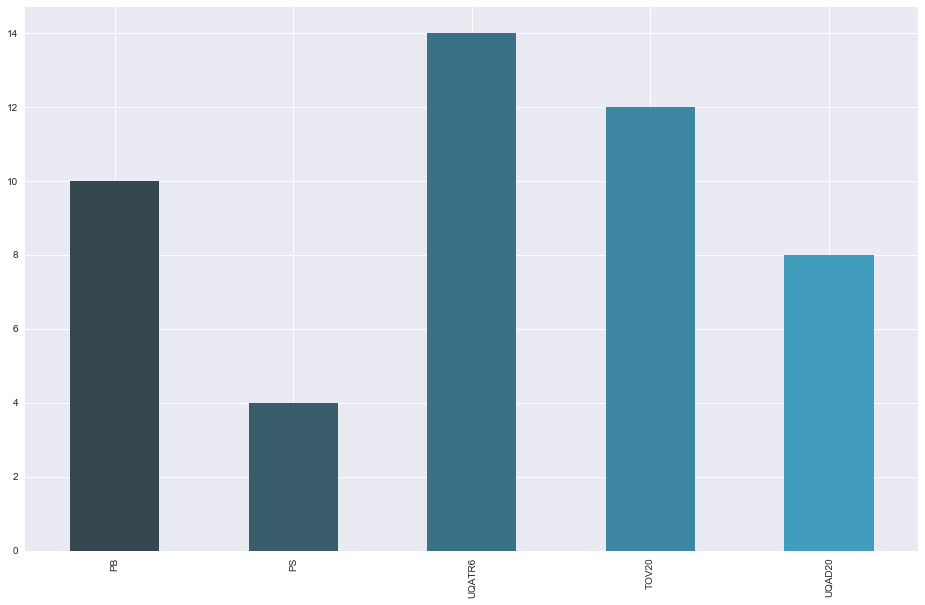

In [22]:
ICFactor[np.abs(ICFactor)>np.abs(ICFactor).mean().mean()].count().plot(figsize=(16,10),kind='bar',color=sns.color_palette("GnBu_d",10))

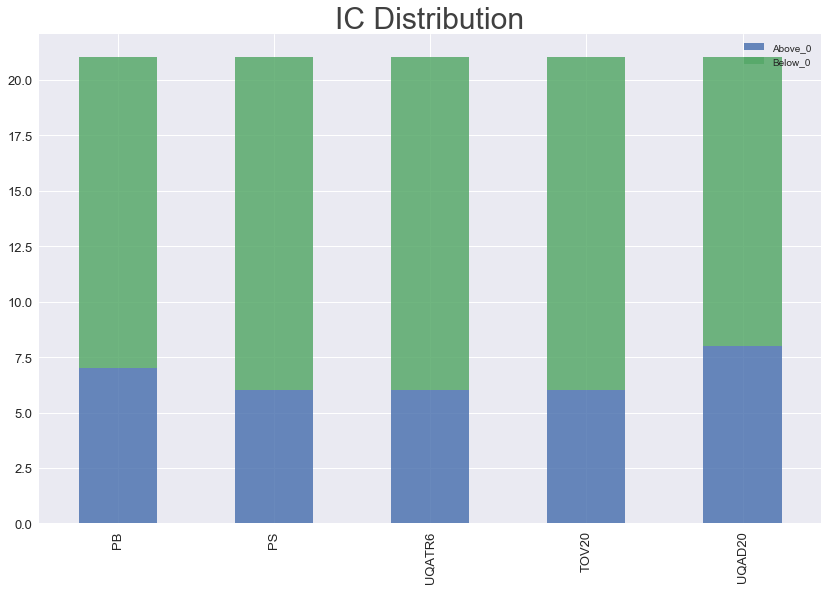

In [23]:
Above0df = ICFactor.astype(float)[ICFactor.astype(float)>0].describe()
Below0df = ICFactor.astype(float)[ICFactor.astype(float)<0].describe()
# show the amount of Negative IC and Positive IC in same figure
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)
totaldf = pd.DataFrame({ 'Above_0':Above0df.loc['count'].values, 'Below_0':Below0df.loc['count'].values},index = Above0df.columns)
totaldf.plot(kind='bar',ax=ax, stacked =True,alpha=0.84,title ='IC Distribution',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.88, fontsize=30)

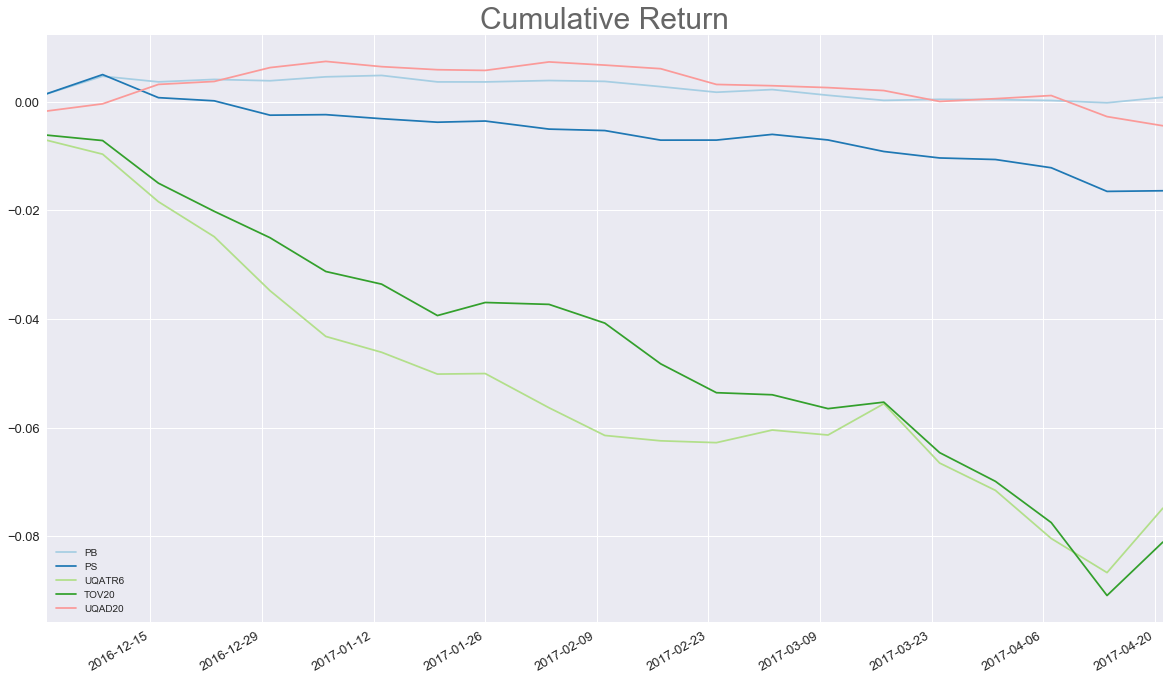

In [24]:
# simple cumulative return 
fig = plt.figure(figsize=(14,9))
# Add a subplot
ax = fig.add_subplot(111)
returnofFactor.cumsum().plot(figsize=(20,12),ax=ax,color=sns.color_palette("Paired",10),title ='Cumulative Return',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30)

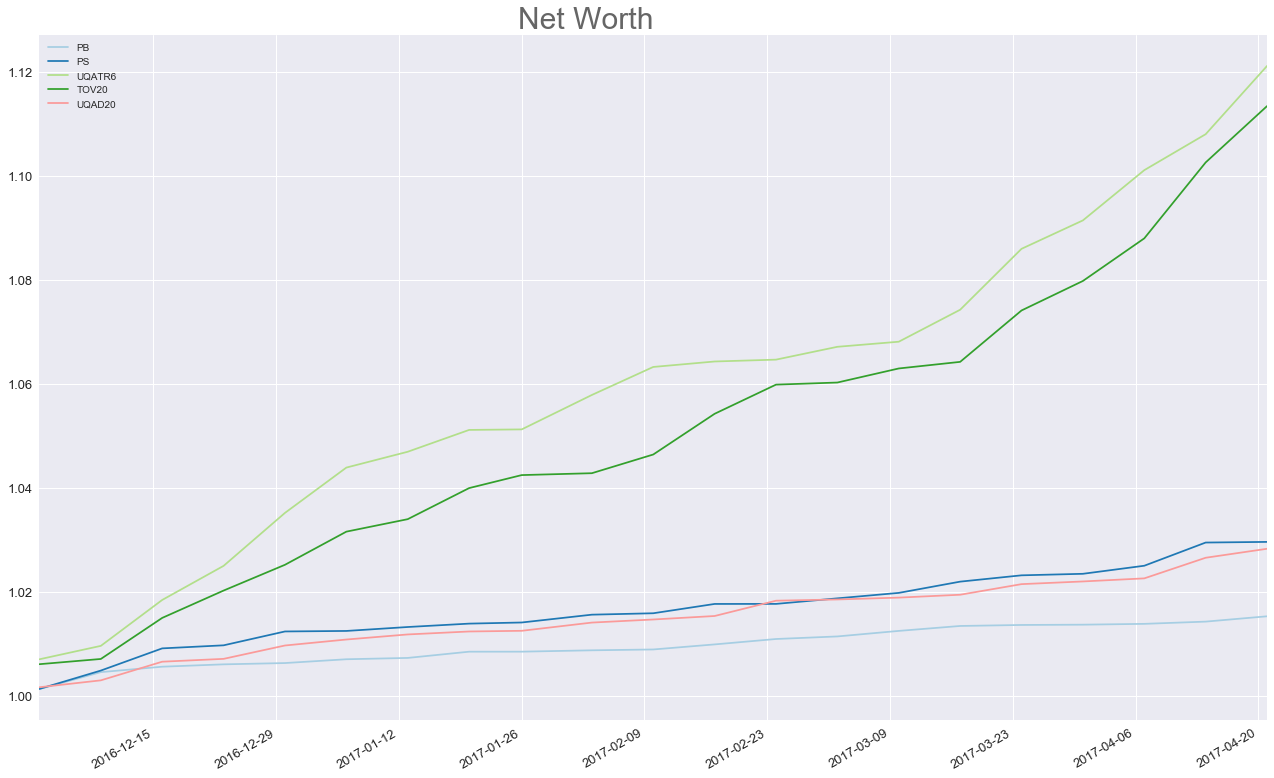

In [25]:
# Net worth plot for each factor
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
(np.abs(returnofFactor)+1).cumprod().plot(figsize=(22,14),ax=ax,color=sns.color_palette("Paired",10),title ='Net Worth',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30, ha='right')

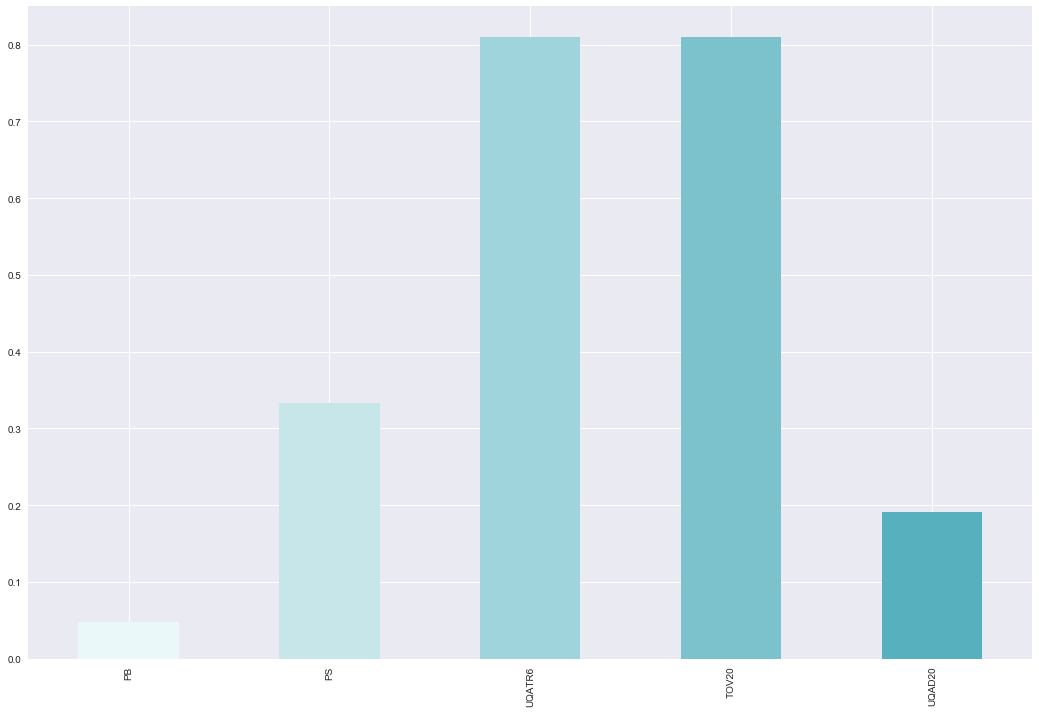

In [26]:
color_set=sns.light_palette((210, 90, 60), input="husl")
(pValueofFactor[pValueofFactor<0.05].count()/len(pValueofFactor)).plot(figsize=(18,12),kind='bar',color=sns.color_palette(color_set,10))

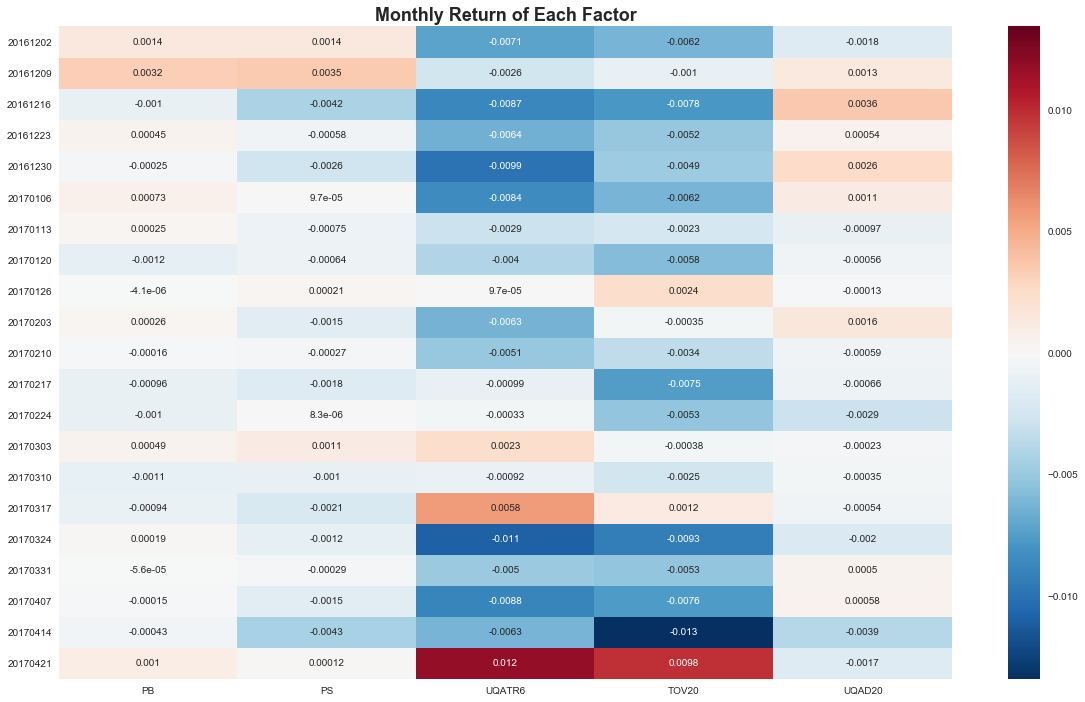

In [27]:
ReturnForPlot = returnofFactor.copy()
ReturnForPlot.index = ReturnForPlot.index.map(lambda x:10000*x.year+100*x.month+x.day)
ReturnForPlot = ReturnForPlot.astype(float)

plt.figure(figsize=(20,12))
ax = plt.axes()
sns.heatmap(ReturnForPlot[-40:],ax=ax, annot=True)
ax.set_title('Monthly Return of Each Factor',fontsize=18, fontweight='bold')
plt.show()

In [28]:
ICFactorTosave = ICFactor.apply(lambda x : x/np.abs(x).sum(),axis=1).shift(1)
ReturnTosave = returnofFactor.apply(lambda x : x/np.abs(x).sum(),axis=1).shift(1)
pWeight = np.exp(-7*pValueofFactor.astype(float)).shift(1)

In [29]:
totalWeighted = (ReturnTosave + ICFactorTosave) * pWeight
totalWeighted

,PB,PS,UQATR6,TOV20,UQAD20
2016-12-02,NaN,NaN,NaN,NaN,NaN
2016-12-09,-0.069067,-0.047262,-0.650699,-0.715036,-0.087494
2016-12-16,0.121354,-0.121181,-0.367402,-0.016306,0.038942
2016-12-23,-0.056972,-0.266055,-0.638545,-0.639310,0.274663
2016-12-30,-0.002507,-0.005442,-0.760358,-0.755884,0.003365
2017-01-06,-0.001131,-0.282716,-0.827336,-0.402116,0.266862
2017-01-13,0.005916,-0.000052,-0.908848,-0.682177,-0.014112
2017-01-20,0.000208,-0.009625,-0.137994,-0.033039,-0.036313
2017-01-26,-0.233064,-0.012772,-0.596711,-0.890499,-0.002155
2017-02-03,-0.000121,-0.001799,-0.001352,1.196105,-0.000051


In [30]:
ReturnTosave.shift(0)

,PB,PS,UQATR6,TOV20,UQAD20
2016-12-02,NaN,NaN,NaN,NaN,NaN
2016-12-09,0.078343,0.079874,-0.398314,-0.345596,-0.097872
2016-12-16,0.278839,0.302357,-0.219638,-0.085581,0.113585
2016-12-23,-0.040857,-0.166854,-0.343671,-0.308109,0.140509
2016-12-30,0.034207,-0.044095,-0.487942,-0.392647,0.041110
2017-01-06,-0.012215,-0.130505,-0.491087,-0.240099,0.126093
2017-01-13,0.043715,0.005851,-0.507246,-0.374585,0.068603
2017-01-20,0.035208,-0.103641,-0.404462,-0.322787,-0.133903
2017-01-26,-0.097673,-0.052789,-0.329032,-0.474302,-0.046204
2017-02-03,-0.001447,0.075175,0.034152,0.844050,-0.045175


In [31]:
ICFactorTosave

,PB,PS,UQATR6,TOV20,UQAD20
2016-12-02,NaN,NaN,NaN,NaN,NaN
2016-12-09,-0.190011,-0.154262,-0.252385,-0.369440,-0.033903
2016-12-16,-0.156785,-0.423797,-0.180914,-0.115308,0.123196
2016-12-23,-0.140429,-0.099202,-0.294874,-0.331201,0.134295
2016-12-30,-0.157765,-0.083624,-0.272416,-0.363237,0.122957
2017-01-06,-0.197660,-0.153362,-0.336249,-0.162017,0.150713
2017-01-13,0.072858,-0.037236,-0.401602,-0.307591,-0.180713
2017-01-20,0.013606,-0.072098,0.263277,0.286001,-0.365018
2017-01-26,-0.251474,-0.059218,-0.267679,-0.416196,-0.005431
2017-02-03,-0.121967,-0.138273,-0.351400,0.352055,0.036305


In [32]:
returnofFactor.iloc[-1].rank()

PB        3.0
PS        2.0
UQATR6    5.0
TOV20     4.0
UQAD20    1.0
Name: 2017-04-21 00:00:00, dtype: float64

In [33]:
ICpValue

,PB,PS,UQATR6,TOV20,UQAD20
2016-12-02,55.004386,55.631789,54.019495,52.190244,57.718556
2016-12-09,56.589212,53.761698,56.352831,57.087509,59.898221
2016-12-16,54.380837,55.531362,50.514259,49.658473,62.665743
2016-12-23,53.793329,55.901931,50.838866,48.645804,62.454120
2016-12-30,53.885010,54.918918,50.951609,54.720517,62.726098
2017-01-06,59.468673,58.324004,54.720135,55.614679,56.859847
2017-01-13,58.972515,57.742380,62.968929,63.352920,53.742670
2017-01-20,53.672403,57.588266,53.393809,50.687846,58.758042
2017-01-26,58.232973,58.172599,56.983179,61.073397,59.178052
2017-02-03,54.345965,54.711146,51.848920,57.358612,65.364117
